In [65]:
using Revise
using QuantumCollocation
using NamedTrajectories
using LinearAlgebra
using SparseArrays
using HDF5

In [2]:
ω = [4.1405, 3.4637, 4.8001, 4.4153]
δ = [225.78, 100.33, 189.32, 172.15] * 1e-3
g = Symmetric([
    0.0 54.38   6.26  2.73;
    0.0   0.0  52.60 41.12;
    0.0   0.0    0.0  6.01;
    0.0   0.0    0.0   0.0
]) * 1e-3

4×4 Symmetric{Float64, Matrix{Float64}}:
 0.0      0.05438  0.00626  0.00273
 0.05438  0.0      0.0526   0.04112
 0.00626  0.0526   0.0      0.00601
 0.00273  0.04112  0.00601  0.0

In [3]:
levels = 3
syss = [
    TransmonSystem(levels=levels, ω=ω[1], δ=δ[1]),
    TransmonSystem(levels=levels, ω=ω[2], δ=δ[2]),
]
coupling_12 = TransmonDipoleCoupling(g[1, 2], (1, 2), syss)

QuantumSystemCoupling(sparse([4, 5, 2, 3, 7, 8, 5, 6], [2, 3, 4, 5, 5, 6, 7, 8], ComplexF64[0.054380000000000005 + 0.0im, 0.07690493352184892 + 0.0im, 0.054380000000000005 + 0.0im, 0.07690493352184892 + 0.0im, 0.07690493352184892 + 0.0im, 0.10876000000000004 + 0.0im, 0.07690493352184892 + 0.0im, 0.10876000000000004 + 0.0im], 9, 9), 0.054380000000000005, (1, 2), [3, 3], QuantumCollocation.QuantumSystemTemplates.TransmonDipoleCoupling, Dict{Symbol, Any}(:lab_frame => false))

In [4]:
csys = CompositeQuantumSystem(syss, [coupling_12])

CompositeQuantumSystem(sparse([2, 4, 3, 5, 2, 3, 5, 7, 6, 8, 5, 7, 6, 8, 9], [2, 2, 3, 3, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8, 9], ComplexF64[-4.252459815899147 + 0.0im, 0.054380000000000005 + 0.0im, -9.135311613667623 + 0.0im, 0.07690493352184892 + 0.0im, 0.054380000000000005 + 0.0im, 0.07690493352184892 + 0.0im, -4.252459815899147 + 0.0im, 0.07690493352184892 + 0.0im, -9.135311613667623 + 0.0im, 0.10876000000000004 + 0.0im, 0.07690493352184892 + 0.0im, -1.4186175786550073 + 0.0im, 0.10876000000000004 + 0.0im, -5.671077394554155 + 0.0im, -10.55392919232263 + 0.0im], 9, 9), SparseMatrixCSC{ComplexF64, Int64}[sparse([4, 5, 6, 1, 7, 2, 8, 3, 9, 4, 5, 6], [1, 2, 3, 4, 4, 5, 5, 6, 6, 7, 8, 9], ComplexF64[6.283185307179586 + 0.0im, 6.283185307179586 + 0.0im, 6.283185307179586 + 0.0im, 6.283185307179586 + 0.0im, 8.885765876316732 + 0.0im, 6.283185307179586 + 0.0im, 8.885765876316732 + 0.0im, 6.283185307179586 + 0.0im, 8.885765876316732 + 0.0im, 8.885765876316732 + 0.0im, 8.885765876316732 + 0.0im, 

In [5]:
op = EmbeddedOperator([:H, :H], csys, 1:2)

EmbeddedOperator(ComplexF64[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.4999999999999999 + 0.0im -0.4999999999999999 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [1, 2, 4, 5], [3, 3])

In [87]:
T = 100
dt = 0.1
prob = UnitarySmoothPulseProblem(csys, op, T, dt; a_bound=0.1)
solve!(prob; max_iter=200)

applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
applying constraint: bounds on Δt
applying constraint: time step all equal constraint
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   572248
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   177185

Total number of variables............................:    17330
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      892
                     variables with only upper bounds:        0
Total number of equality constraints.................:    16929
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality 

In [88]:
unitary_fidelity(prob; subspace=op.subspace_indices)

0.9995665309258068

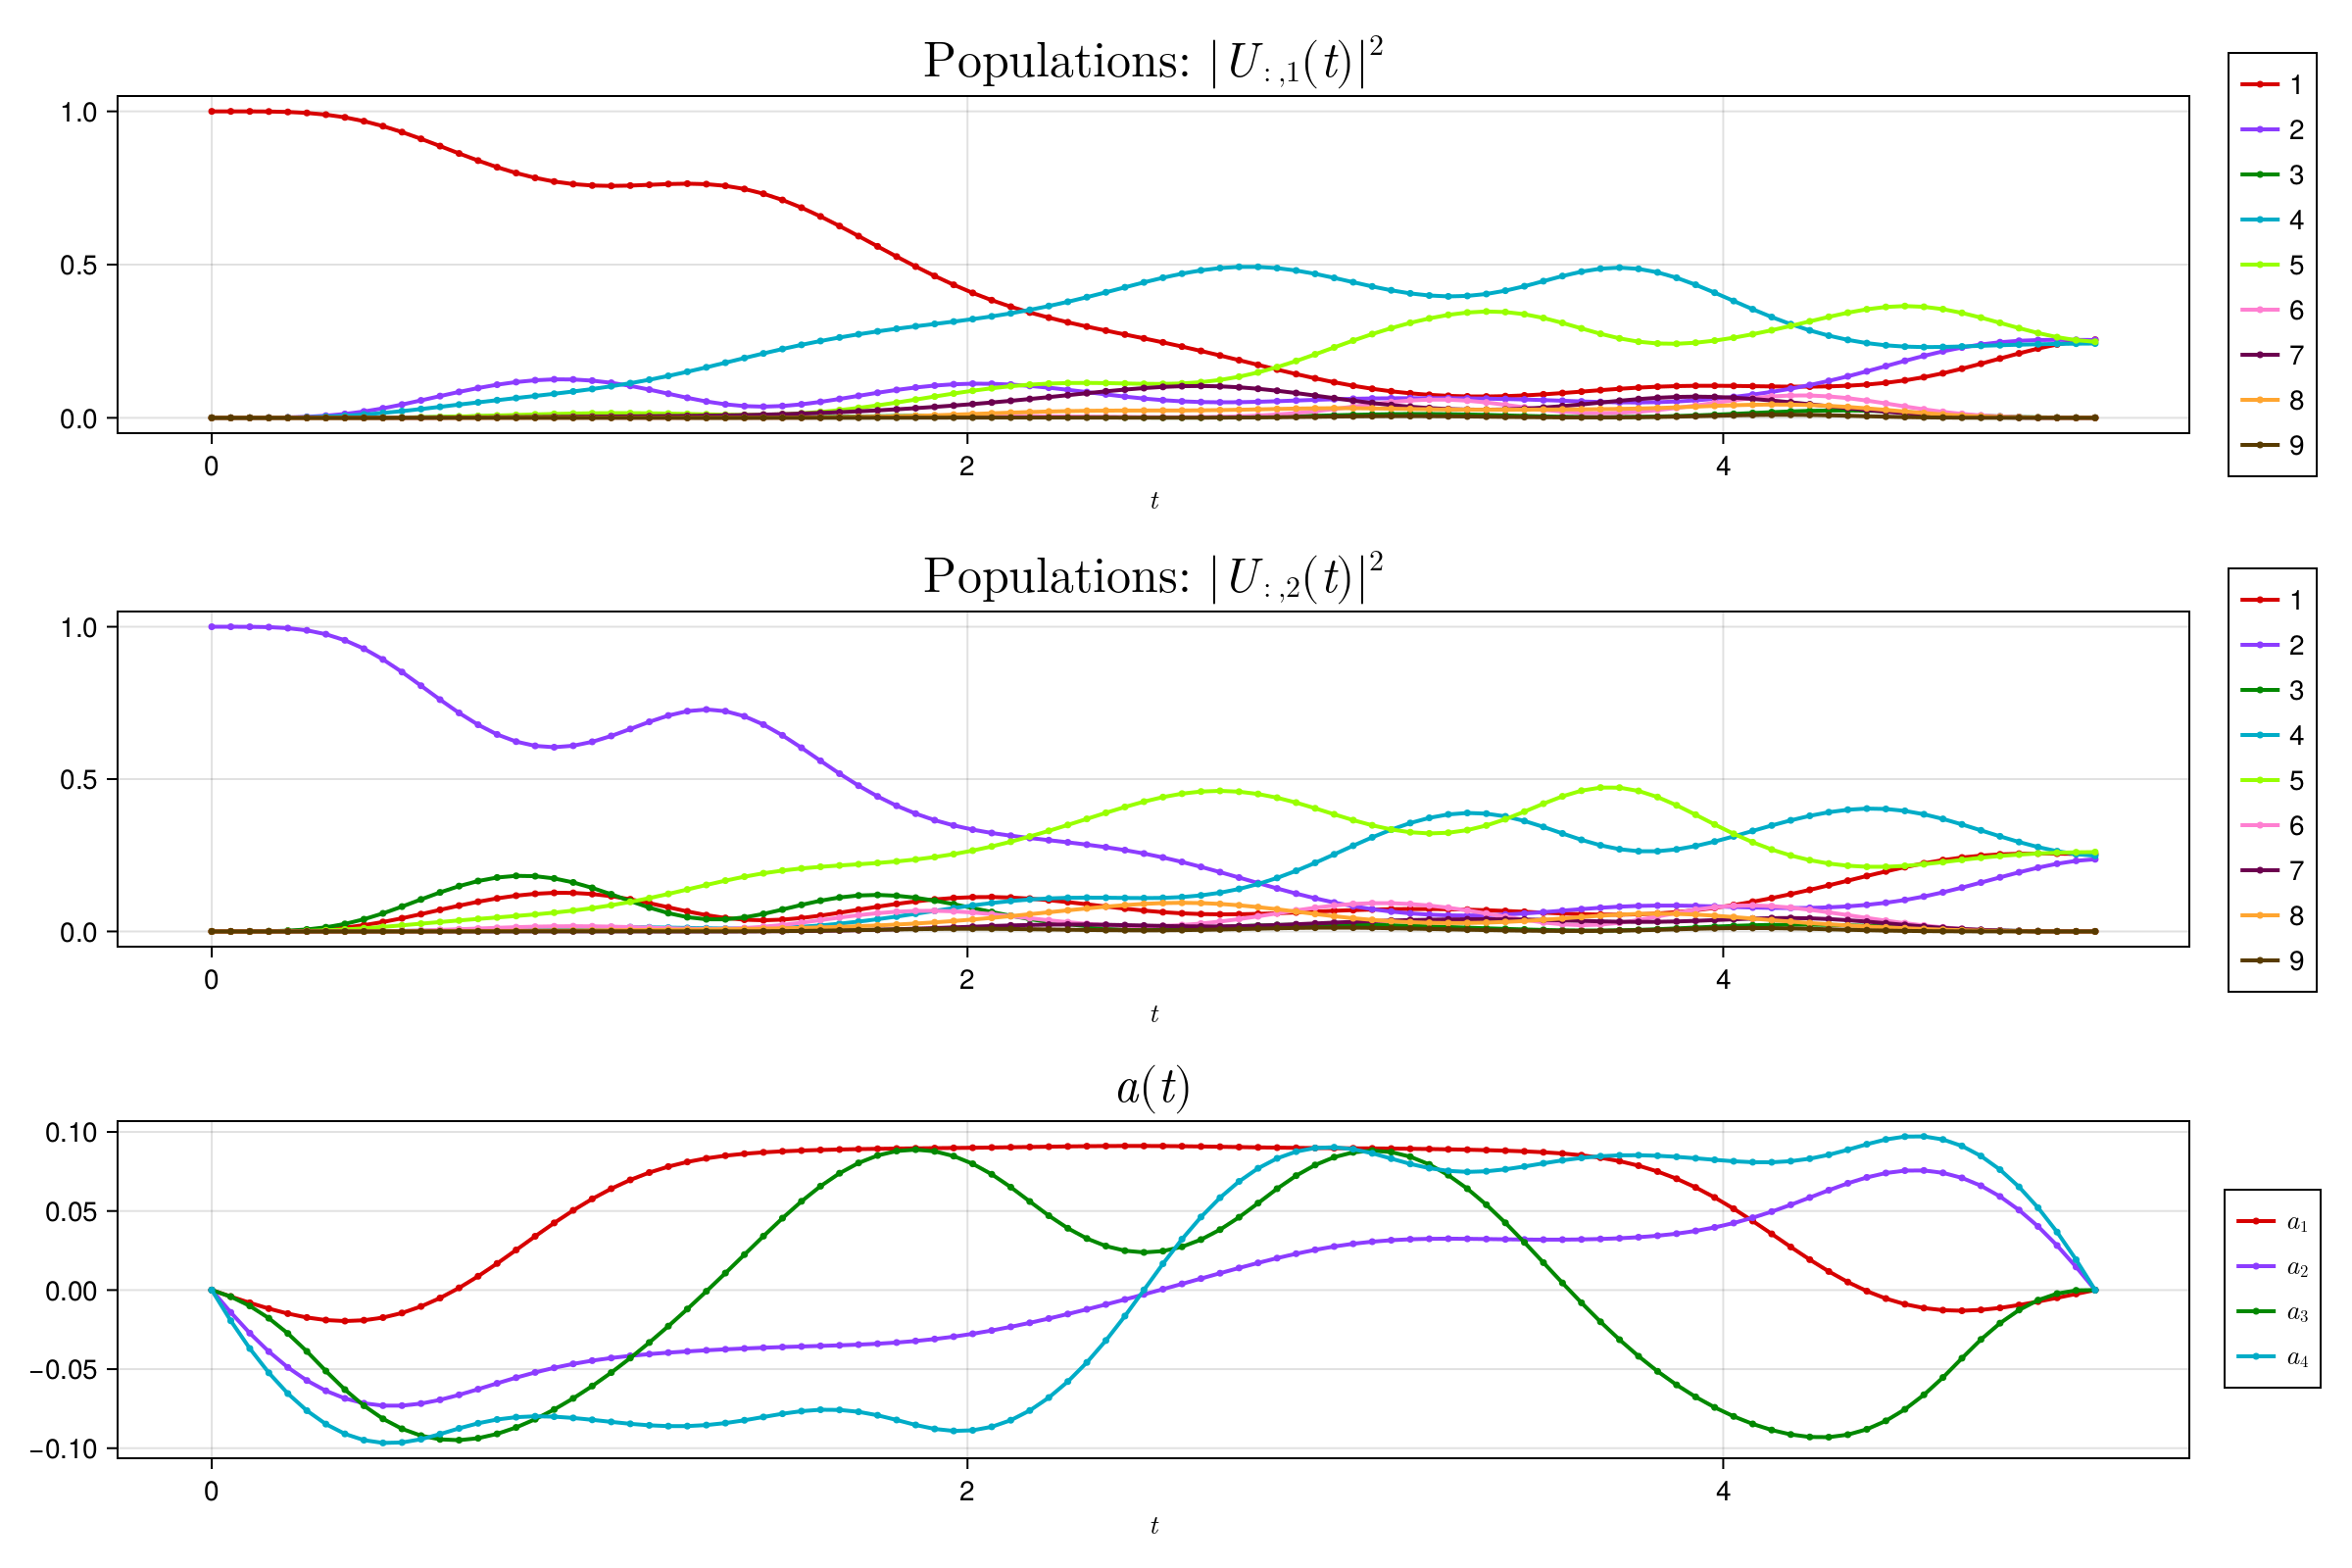

In [106]:
fig = unitary_populations_plot(prob)
save("unitary_populations.png", fig)
fig


In [90]:
function MultiTransmonSystem(
    ωs::AbstractVector{Float64},
    δs::AbstractVector{Float64},
    gs::AbstractMatrix{Float64};
    levels_per_transmon::Int = 3,
    subsystem_levels::AbstractVector{Int} = fill(levels_per_transmon, length(ωs)),
    lab_frame=false,
    subsystems::AbstractVector{Int} = 1:length(ωs),
    kwargs...
)
    n_subsystems = length(ωs)
    @assert length(δs) == n_subsystems
    @assert size(gs) == (n_subsystems, n_subsystems)

    syss = [
        TransmonSystem(levels=levels, ω=ω, δ=δ, lab_frame=lab_frame) 
            for (i, (ω, δ, levels)) ∈ enumerate(zip(ωs, δs, subsystem_levels))
                if i ∈ subsystems
    ]

    couplings = QuantumSystemCoupling[]

    for i = 1:n_subsystems-1
        for j = i+1:n_subsystems
            if i ∈ subsystems &&  j ∈ subsystems
                push!(
                    couplings, 
                    TransmonDipoleCoupling(gs[i, j], (i, j), syss; lab_frame=lab_frame)
                )
            end
        end
    end

    return CompositeQuantumSystem(syss, couplings)
end

MultiTransmonSystem (generic function with 1 method)

In [91]:
csys_full = MultiTransmonSystem(ω, δ, g)
csys_full_decoupled = CompositeQuantumSystem(
    csys_full.subsystems, 
    csys_full.couplings[1:1]
)
[c.pair for c in csys_full_decoupled.couplings]

1-element Vector{Tuple{Int64, Int64}}:
 (1, 2)

In [92]:
csys_duplicate = MultiTransmonSystem(ω, δ, g; subsystems=[1,2])
csys_duplicate.H_drives .== csys.H_drives

4-element BitVector:
 1
 1
 1
 1

In [93]:
controls_full = vcat(prob.trajectory.a, zeros(size(prob.trajectory.a)))


8×100 Matrix{Float64}:
 0.0  -0.00409972  -0.00806407  -0.0117217  …  -0.00489934  -0.00244965  0.0
 0.0  -0.0141359   -0.0272486   -0.0389047      0.0281828    0.0146232   0.0
 0.0  -0.00418117  -0.0100374   -0.0177956     -0.0022318   -0.00018752  0.0
 0.0  -0.0194227   -0.0369649   -0.0523389      0.0366691    0.0191933   0.0
 0.0   0.0          0.0          0.0            0.0          0.0         0.0
 0.0   0.0          0.0          0.0        …   0.0          0.0         0.0
 0.0   0.0          0.0          0.0            0.0          0.0         0.0
 0.0   0.0          0.0          0.0            0.0          0.0         0.0

In [94]:
op_full = EmbeddedOperator([:H, :H], csys_full, 1:2)
op_full.operator |> sparse

81×81 SparseMatrixCSC{ComplexF64, Int64} with 64 stored entries:
⎡⠑⢀⠀⠀⠈⠂⡀⠀⠀⠀⠀⠀⠀⠈⠂⡀⠀⠀⠑⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠁⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠢⠀⠀⠀⠐⠄⠀⠀⠀⠀⠀⠀⠀⠐⠄⠀⠀⠀⠢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠈⠂⠀⠀⠀⠑⠀⠀⠀⠀⠀⠀⠀⠀⠑⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⡀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠠⡀⠀⠀⠁⢄⠀⠀⠀⠀⠀⠀⠀⠁⢄⠀⠀⠈⢠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠑⢀⡀⠀⠈⠂⣀⠀⠀⠀⠀⠀⠀⠈⠂⣀⠀⠀⠑⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

In [95]:
unitary_fidelity(
    op.operator, 
    prob.trajectory.a, 
    prob.trajectory.Δt, 
    csys_duplicate; 
    subspace=op.subspace_indices
)

0.9995665309258068

In [111]:
Ũ⃗ = unitary_rollout(
    controls_full, 
    prob.trajectory.Δt, 
    csys_full 
)
U_T = iso_vec_to_operator(Ũ⃗[:, end])
display(populations(U_T[:,1][op_full.subspace_indices]))
unitary_fidelity(U_T, op_full.operator; subspace=op_full.subspace_indices)

16-element Vector{Float64}:
 0.25510533307412336
 1.918458455441099e-5
 1.6569064258757925e-5
 1.2737570856110949e-9
 0.2535016019405399
 2.043854398916528e-5
 1.4464459859991009e-6
 1.2727523360395013e-9
 0.24292203511335175
 1.9938784465674817e-5
 1.1125326757619912e-5
 1.566820842769038e-9
 0.24780160439105559
 4.0320781458800786e-5
 4.1011507516913945e-7
 7.376160812121104e-10

0.2457357576624668

In [97]:
ψ = quantum_state("gggg", csys_full)
ψ_goal = op_full.operator * ψ


81-element Vector{ComplexF64}:
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                    ⋮
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

In [98]:
ψ_nom = quantum_state("gg", csys)
ψ_goal_nom = op.operator * ψ_nom
display(ψ_nom)
display(ψ_goal_nom)


9-element Vector{ComplexF64}:
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

9-element Vector{ComplexF64}:
 0.4999999999999999 + 0.0im
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
 0.4999999999999999 + 0.0im
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

In [99]:
quantum_state("(g+e)(g+e)", csys)

9-element Vector{ComplexF64}:
 0.4999999999999999 + 0.0im
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
 0.4999999999999999 + 0.0im
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

In [100]:
ψ̃_T = rollout(ψ_nom, prob.trajectory.a, prob.trajectory.Δt, csys)[:, end]
ψ_T = iso_to_ket(ψ̃_T)
display(populations(ψ_T))
display(populations(ψ_goal_nom))
fidelity(ψ_T, ψ_goal_nom)

9-element Vector{Float64}:
 0.2547912252997867
 0.2539605036906749
 0.00033866498758473667
 0.2425192384557516
 0.2482038441862999
 3.6433334274846405e-5
 0.00010806202622326385
 2.6928784731798385e-5
 1.509923467516494e-5

9-element Vector{Float64}:
 0.2499999999999999
 0.2499999999999999
 0.0
 0.2499999999999999
 0.2499999999999999
 0.0
 0.0
 0.0
 0.0

0.9825476079851662

In [107]:
ψ̃_T = rollout(ψ, controls_full, prob.trajectory.Δt, csys_full)[:, end]
ψ_T = iso_to_ket(ψ̃_T)
display(populations(ψ_T[op_full.subspace_indices]))
fidelity(ψ_T, ψ_goal; subspace=op_full.subspace_indices)

16-element Vector{Float64}:
 0.2550957349878743
 1.9187376171849347e-5
 1.6568941705837175e-5
 1.2733218492638683e-9
 0.2534991441608018
 2.0428643038433053e-5
 1.4479540730481887e-6
 1.2729170674483697e-9
 0.24290559709640439
 1.9939348219312204e-5
 1.1126528152807555e-5
 1.5664097453686287e-9
 0.24782544517956778
 4.030913998071982e-5
 4.099706380647021e-7
 7.381754531386743e-10

0.9821015272395281

In [114]:
ψ_goal[op_full.subspace_indices]

16-element Vector{ComplexF64}:
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
 0.4999999999999999 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

In [103]:
pulse_save_path = joinpath(@__DIR__, "plus_plus_pulse_a_bound_0.1.h5")

h5open(pulse_save_path, "w") do file
    write(file, "a", prob.trajectory.a)
    write(file, "times", get_times(prob.trajectory))
end

In [72]:
# test loading the pulse
pulse = h5open(pulse_save_path, "r")
pulse["a"][:,:]
pulse["times"][:]

100-element Vector{Float64}:
 0.0
 0.09547915185821089
 0.19095830371642178
 0.2864374555746327
 0.38191660743284356
 0.47739575929105443
 0.5728749111492654
 0.6683540630074762
 0.7638332148656871
 0.859312366723898
 0.9547915185821089
 1.0502706704403197
 1.1457498222985307
 ⋮
 8.402165363522546
 8.497644515380756
 8.593123667238967
 8.688602819097177
 8.784081970955388
 8.879561122813598
 8.975040274671809
 9.07051942653002
 9.16599857838823
 9.26147773024644
 9.356956882104651
 9.452436033962861